- Required snowflake-ml-python version: >=**1.6.0**
- Updated on: 7/25/2024

# Manage features in DBT with Feature Store

This notebook showcases the interoperation between DBT and Snowflake Feature Store. The source data is managed in Snowflake database, while the feature pipelines are managed and executed from DBT. The output is stored as feature tables in Snowflake. Then We read from the feature tables and register them as external Feature View.

This demo requires DBT account.

## Set up Snowflake connection

In [1]:
from snowflake.snowpark import Session, context, exceptions

try:
    # Retrieve active session if in Snowpark Notebook
    session = context.get_active_session()
except exceptions.SnowparkSessionException:
    # ACTION REQUIRED: Need to manually configure Snowflake connection if using Jupyter
    connection_parameters = {
        "account": "<your snowflake account>",
        "user": "<your snowflake user>",
        "password": "<your snowflake password>",
        "role": "<your snowflake role>",
        "warehouse": "<your snowflake warehouse>",
        "database": "<your snowflake database>",
        "schema": "<your snowflake schema>",
    }

    session = Session.builder.configs(connection_parameters).create()

assert session.get_current_database() != None, "Session must have a database for the demo."
assert session.get_current_warehouse() != None, "Session must have a warehouse for the demo."

Create test schema. It will be deleted at the end of notebook.

In [2]:
# database name where test data and feature store lives.
# This name must be same with the one you used in schema.yaml in DBT.
FS_DEMO_DB = f"SNOWML_FEATURE_STORE_DBT_DEMO"
# feature store (schema) name.
# This must be same with the one you used in schema.yaml in DBT.
FS_DEMO_SCHEMA = "FS_DBT_DEMO"

session.sql(f"CREATE OR REPLACE DATABASE {FS_DEMO_DB}").collect()
session.sql(f"CREATE OR REPLACE SCHEMA {FS_DEMO_DB}.{FS_DEMO_SCHEMA}").collect()

[Row(status='Schema FS_DBT_DEMO successfully created.')]

## Load source data

This notebook will use public `fraud_transactions` data as source. It contains transaction data range between [2019-04-01, 2019-09-01). We will split this dataset into two parts based on its timestamp. The first part includes rows before 2019-07-01, the second part includes rows after 2019-07-01. We copy the first part into `CUSTOMER_TRANSACTIONS_FRAUD` table now. And will copy second part into same table later.

In [3]:
from snowflake.ml.feature_store.examples.example_helper import ExampleHelper

helper = ExampleHelper(session, FS_DEMO_DB, FS_DEMO_SCHEMA)
source_table = helper.load_source_data('fraud_transactions')[0]
print(f"New source table: {source_table}.")
session.table(source_table).limit(5).to_pandas()

New source table: SNOWML_FEATURE_STORE_DBT_DEMO.FS_DBT_DEMO.fraud_transactions.


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,1,2019-04-01 00:02:10,4961,3412,81.51,130,0,0,0
1,2,2019-04-01 00:07:56,2,1365,146.00,476,0,0,0
2,3,2019-04-01 00:09:29,4128,8737,64.49,569,0,0,0
3,4,2019-04-01 00:10:34,927,9906,50.99,634,0,0,0
4,5,2019-04-01 00:10:45,568,8803,44.71,645,0,0,0


In [5]:
fraud_data_path = f"{FS_DEMO_DB}.{FS_DEMO_SCHEMA}.CUSTOMER_TRANSACTIONS_FRAUD"
session.sql(f"""
    CREATE OR REPLACE TABLE {fraud_data_path} AS
    SELECT *
    FROM {source_table}
    WHERE TX_DATETIME < '2019-07-01'
""").collect()
session.table(fraud_data_path).count()

872794

## Define models in DBT
Now lets switch to [DBT IDE](https://cloud.getdbt.com/develop/15898/projects/334785)(this link will not work for you, you will need to create your own project) for a while. You will need a DBT account beforehand. Once you have DBT account, then you can clone the demo code from [here](https://github.com/sfc-gh-wezhou/FS_DBT_DEMO/tree/dev/models/example) (Snowflake repo). Below screenshot shows how DBT IDE looks like. In the file explorer section, you can see the code structure. Our [DBT models](https://docs.getdbt.com/docs/build/python-models) defined under models/example folder. We have 3 models: customers, terminals and transactions. These 3 models will later output 3 Snowflake DataFrame object. Lastly, Feature Store will register these DataFrames and make them FeatureViews.

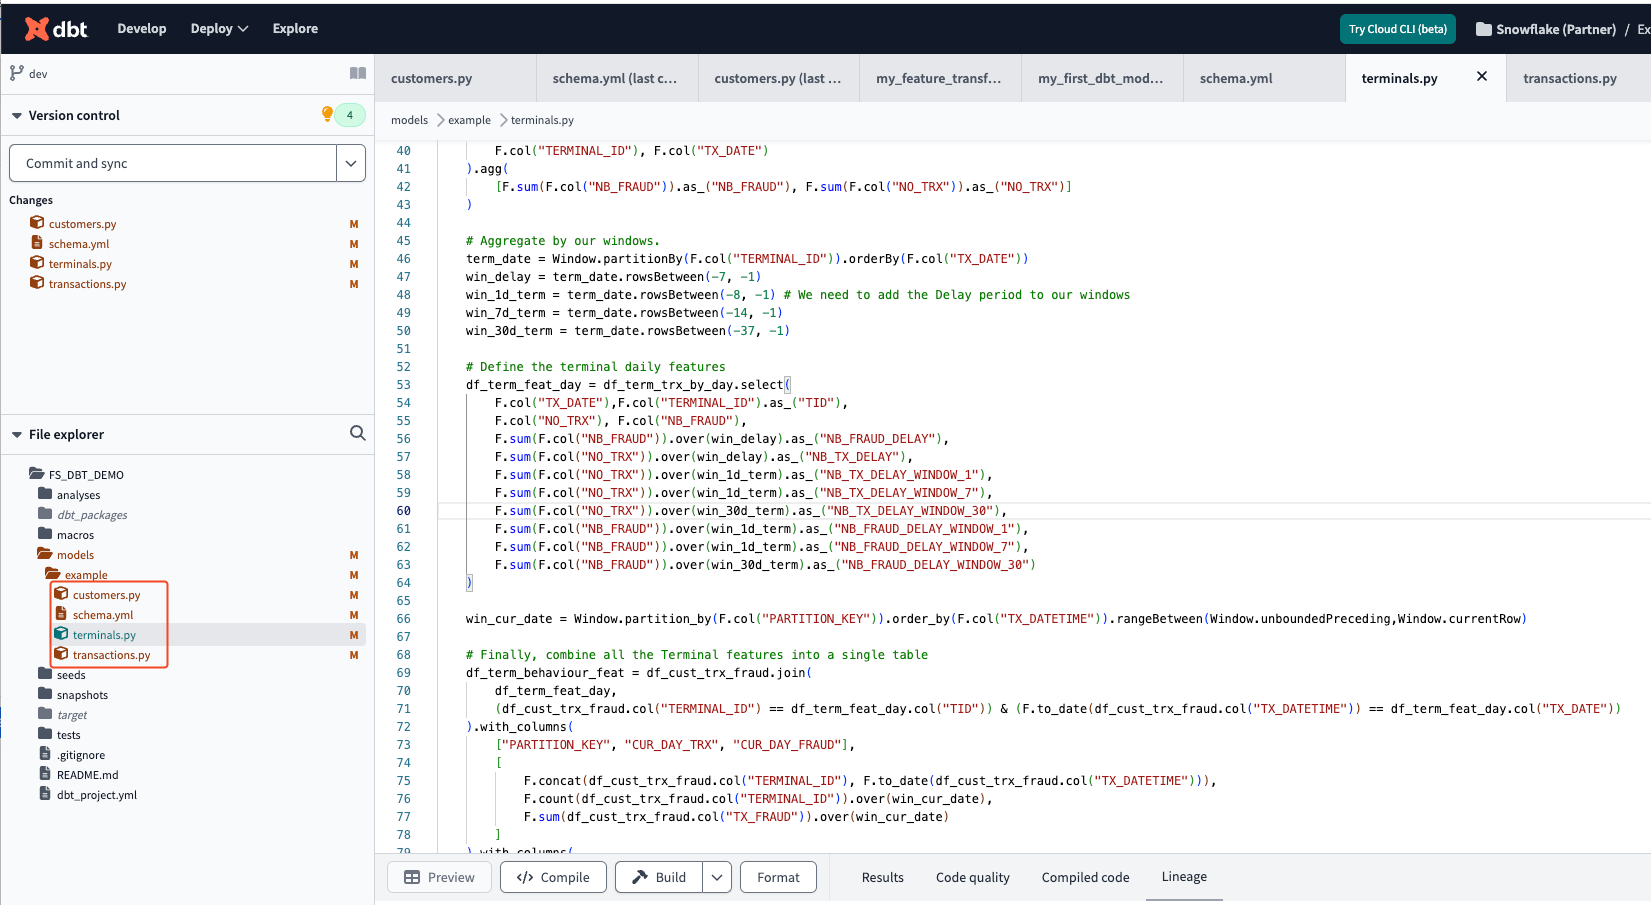

## Run models in DBT
After we defined models, now we can run and generate our feature tables. Simple exeucte `dbt run` in the terminal and it will do all the work. 

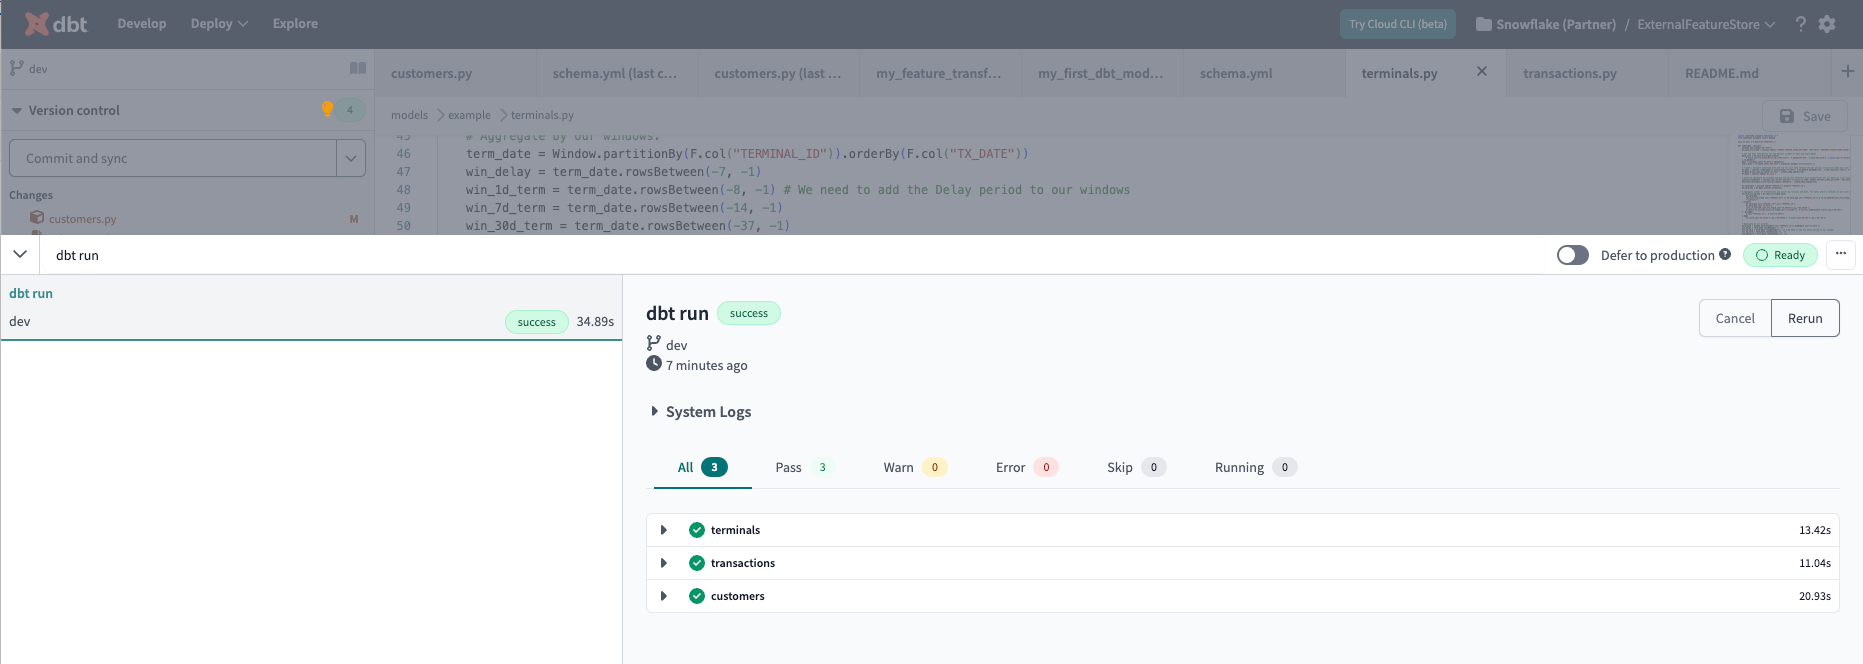

After the run success, we will see feature tables are populated with values.

In [6]:
# replace 'transactions' with 'customers' or 'terminals' to show 
# respective table.
table_schema = f"{FS_DEMO_DB}.FS_DBT_DEMO_{FS_DEMO_SCHEMA}"
session.sql(f"SELECT * FROM {table_schema}.transactions").show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRANSACTION_ID"  |"CUSTOMER_ID"  |"TERMINAL_ID"  |"TX_DATETIME"        |"EVENT_TIMESTAMP"    |"CT_DATETIME"                     |"TX_AMOUNT"  |"TX_TIME_SECONDS"  |"TX_TIME_DAYS"  |"TX_FRAUD"  |"TX_FRAUD_SCENARIO"  |"TX_DURING_WEEKEND"  |"TX_DURING_NIGHT"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1                 |4961           |3412           |2019-04-01 00:02:10  |2019-04-01 00:02:10  |2024-07-19 14:28:36.956000-07:00  |81.51        |130                |0               |0           |0                    |0  

## Register feature tables as Feature Views

Now lets create Feature Views with Feature Store. Since DBT is responsible for executing the pipeline, the feature tables will be registered as external pipeline. Underlying, it creates views, instead of dynamic tables, from the feature tables.

Replace below `default_warehouse` with your warehouse in your environment.

In [7]:
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

fs = FeatureStore(
    session=session, 
    database=FS_DEMO_DB, 
    name=FS_DEMO_SCHEMA, 
    default_warehouse='REGTEST_ML_4XL_MULTI',
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

Register entities for features.

In [8]:
customer = Entity(name="CUSTOMER", join_keys=["CUSTOMER_ID"])
terminal = Entity(name="TERMINAL", join_keys=["TERMINAL_ID"])
transaction = Entity(name="TRANSACTION", join_keys=["TRANSACTION_ID"])
fs.register_entity(customer)
fs.register_entity(terminal)
fs.register_entity(transaction)
fs.list_entities().show()

----------------------------------------------------------
|"NAME"       |"JOIN_KEYS"         |"DESC"  |"OWNER"     |
----------------------------------------------------------
|CUSTOMER     |["CUSTOMER_ID"]     |        |REGTEST_RL  |
|TERMINAL     |["TERMINAL_ID"]     |        |REGTEST_RL  |
|TRANSACTION  |["TRANSACTION_ID"]  |        |REGTEST_RL  |
----------------------------------------------------------



Define feature views. `feature_df` is a dataframe object that selects from a subset of columns of feature tables. `refresh_freq` is None indicates it is static and won't be refreshed. Underlying it will create views on the feature tables.

In [9]:
# terminal features
terminals_df = session.sql(f"""
    SELECT 
        TERMINAL_ID,
        EVENT_TIMESTAMP,
        TERM_RISK_1,
        TERM_RISK_7,
        TERM_RISK_30
    FROM {FS_DEMO_DB}.FS_DBT_DEMO_{FS_DEMO_SCHEMA}.terminals
    """)
terminals_fv = FeatureView(
    name="terminal_features", 
    entities=[terminal],
    feature_df=terminals_df,
    timestamp_col="EVENT_TIMESTAMP",
    refresh_freq=None,
    desc="A bunch of terminal related features")

# customer features
customers_df = session.sql(f"""
    SELECT 
        CUSTOMER_ID,
        EVENT_TIMESTAMP,
        CUST_AVG_AMOUNT_1,
        CUST_AVG_AMOUNT_7,
        CUST_AVG_AMOUNT_30
    FROM {FS_DEMO_DB}.FS_DBT_DEMO_{FS_DEMO_SCHEMA}.customers
    """)
customers_fv = FeatureView(
    name="customers_features", 
    entities=[customer],
    feature_df=customers_df,
    timestamp_col="EVENT_TIMESTAMP",
    refresh_freq=None,
    desc="A bunch of customer related features")

# transaction features
transactions_df = session.sql(f"""
    SELECT 
        TRANSACTION_ID, 
        EVENT_TIMESTAMP, 
        TX_AMOUNT,
        TX_FRAUD
    FROM {FS_DEMO_DB}.FS_DBT_DEMO_{FS_DEMO_SCHEMA}.transactions
    """)
transactions_fv = FeatureView(
    name="transactions_features", 
    entities=[transaction],
    feature_df=transactions_df,
    timestamp_col="EVENT_TIMESTAMP",
    refresh_freq=None,
    desc="A bunch of transaction related features")

Register these feature views in feature store so you can retrieve them back later even after notebook session is destroyed. 

In [10]:
terminals_fv = fs.register_feature_view(
    feature_view=terminals_fv,
    version="1",
    block=True)

customers_fv = fs.register_feature_view(
    feature_view=customers_fv,
    version="1",
    block=True)

transactions_fv = fs.register_feature_view(
    feature_view=transactions_fv,
    version="1",
    block=True)

Lets check whether feature views are reigstered successfully in feature store. You will see 3 registerd feature views.

In [11]:
# display as pandas dataframe
fs.list_feature_views().to_pandas()

,NAME,VERSION,DATABASE_NAME,SCHEMA_NAME,CREATED_ON,OWNER,DESC,ENTITIES,REFRESH_FREQ,REFRESH_MODE,SCHEDULING_STATE,WAREHOUSE
0,CUSTOMERS_FEATURES,1,SNOWML_FEATURE_STORE_DBT_DEMO,FS_DBT_DEMO,2024-07-19 14:30:04.939,REGTEST_RL,A bunch of customer related features,"[\n ""CUSTOMER""\n]",None,None,None,None
1,TERMINAL_FEATURES,1,SNOWML_FEATURE_STORE_DBT_DEMO,FS_DBT_DEMO,2024-07-19 14:30:00.791,REGTEST_RL,A bunch of terminal related features,"[\n ""TERMINAL""\n]",None,None,None,None
2,TRANSACTIONS_FEATURES,1,SNOWML_FEATURE_STORE_DBT_DEMO,FS_DBT_DEMO,2024-07-19 14:30:08.696,REGTEST_RL,A bunch of transaction related features,"[\n ""TRANSACTION""\n]",None,None,None,None


## Generate training dataset with point-in-time correctness
We can now generate training dataset with feature views. Firstly, we create a mock spine dataframe which has 3 columns: instance_id, customer_id and event_timestamp. Note the event_timestamp of 3 rows are same: "2019-09-01 00:00:00.000". Later, we will update the source table (`CUSTOMER_TRANSACTIONS_FRAUD`) and feature tables with newer events. We will still use this `spine_df` with same timestamp to generate dataset but it is expected to output a different training data. The new training data will join spine_df with latest feature values from newer events. 

In [12]:
spine_df = session.create_dataframe(
    [
        (1, 2443, "2019-09-01 00:00:00.000"), 
        (2, 1889, "2019-09-01 00:00:00.000"),
        (3, 1309, "2019-09-01 00:00:00.000")
    ], 
    schema=["INSTANCE_ID", "CUSTOMER_ID", "EVENT_TIMESTAMP"])

my_dataset = fs.generate_dataset(
    name="my_training_dataset_from_dbt",
    version="1_0",
    spine_df=spine_df,
    features=[customers_fv],
    spine_timestamp_col="EVENT_TIMESTAMP",
    spine_label_cols = []
)

We can convert dataset to snowpark dataframe and examine feature values.

In [13]:
training_data_df = my_dataset.read.to_snowpark_dataframe()
training_data_df.show()

------------------------------------------------------------------------------------------------------------------------------
|"INSTANCE_ID"  |"CUSTOMER_ID"  |"EVENT_TIMESTAMP"        |"CUST_AVG_AMOUNT_1"  |"CUST_AVG_AMOUNT_7"  |"CUST_AVG_AMOUNT_30"  |
------------------------------------------------------------------------------------------------------------------------------
|2              |1889           |2019-09-01 00:00:00.000  |112.26750183105469   |102.57643127441406   |101.19486236572266    |
|1              |2443           |2019-09-01 00:00:00.000  |61.54777908325195    |88.3499984741211     |96.53591918945312     |
|3              |1309           |2019-09-01 00:00:00.000  |38.52000045776367    |81.85333251953125    |93.1205062866211      |
------------------------------------------------------------------------------------------------------------------------------



## Update features from DBT
Now we are injecting newer events into source, then refresh the pipeline and generate new feature values. We firstly check how many rows the source table currently has.

In [14]:
session.table(fraud_data_path).count()

872794

We inject new events with timestamp later than '2019-07-01'. Then check how many rows in the source table after the injection.

In [15]:
session.sql(f"""
    INSERT INTO {fraud_data_path}
    SELECT *
    FROM {source_table}
    WHERE TX_DATETIME >= '2019-07-01'
""").collect()
session.table(fraud_data_path).count()

1466281

Then, we go back to DBT IDE and run the pipelines again.

## Generate new training dataset
We don't need to update feature views because the underlying tables are updated by DBT. We only need to generate dataset again with same timestamp and it will join with newer feature values.

In [16]:
new_dataset = fs.generate_dataset(
    name="my_training_dataset_from_dbt",
    version="2_0",
    spine_df=spine_df,
    features=[customers_fv],
    spine_timestamp_col="EVENT_TIMESTAMP",
    spine_label_cols = [],
)

new_training_data_df = new_dataset.read.to_snowpark_dataframe()
new_training_data_df.show()

------------------------------------------------------------------------------------------------------------------------------
|"INSTANCE_ID"  |"CUSTOMER_ID"  |"EVENT_TIMESTAMP"        |"CUST_AVG_AMOUNT_1"  |"CUST_AVG_AMOUNT_7"  |"CUST_AVG_AMOUNT_30"  |
------------------------------------------------------------------------------------------------------------------------------
|3              |1309           |2019-09-01 00:00:00.000  |38.52000045776367    |81.85333251953125    |93.1205062866211      |
|2              |1889           |2019-09-01 00:00:00.000  |112.26750183105469   |102.57643127441406   |101.19486236572266    |
|1              |2443           |2019-09-01 00:00:00.000  |61.54777908325195    |88.3499984741211     |96.53591918945312     |
------------------------------------------------------------------------------------------------------------------------------



## Cleanup notebook

In [17]:
session.sql(f"DROP DATABASE IF EXISTS {FS_DEMO_DB}").collect()

[Row(status='SNOWML_FEATURE_STORE_DBT_DEMO successfully dropped.')]